In [51]:
import os

import numpy as np
import pickle
import time
import pandas as pd

from tqdm.auto import tqdm

import INN
import torch
import torch.nn.functional as F
from torch.optim import Adam
from IPython.display import clear_output

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, confusion_matrix

import GPy
import optunity as opt
import sobol as sb

import scipy.stats as stats

import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [3]:
train = True

# Data

In [4]:
with open('../data/data_train.pt', 'rb') as file:
    X_train, y_train = pickle.load(file)

X_train = X_train
y_train = y_train

print(f'{X_train.shape = }')
print(f'{y_train.shape = }')

X_train.shape = (2521156, 28)
y_train.shape = (2521156, 2)


# Parameter Optimization

In [5]:
INN_parameters = {
    'in_features': X_train.shape[1],
    'out_features': y_train.shape[1],
    'device': device
}

loss_weights = {
    'bce_factor': 10,
    'dvg_factor': 1,
    'logdet_factor': 1,
    'rcst_factor': 1
}

lr = 5e-4

In [6]:
n_epochs = 6
batch_size = 1024

In [7]:
hyperparameter_search_space_boundaries = {
    'n_blocks': [1, 12],
    'n_coupling_network_hidden_layers': [1, 5],
    'n_coupling_network_hidden_nodes': [4, 512 + 256],
}

In [8]:
def scale_hyperparameters(hyperparameters):
    return np.array([h * (boundaries[1] - boundaries[0]) + boundaries[0] for h, boundaries in zip(hyperparameters, hyperparameter_search_space_boundaries.values())])

## Cross-Validation: Helper Functions

In [9]:
def count_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params += param
    return total_params

In [10]:
def get_mean_CV_Score(score_function, hyperparameters, progress_bar_kwargs=None):
    n_blocks, n_coupling_network_hidden_layers, n_coupling_network_hidden_nodes = hyperparameters

    kf = KFold(n_splits=5, shuffle=True, random_state=20210927)

    log_loss_list = np.empty(5, dtype=np.float64)

    for split_index, (fit_index, val_index) in enumerate(kf.split(X_train)):
        # create splits
        X_fit, X_val = X_train[fit_index], X_train[val_index]
        y_fit, y_val = torch.Tensor(y_train[fit_index]).to(device), y_train[val_index]

        # scale features
        sc_X_fit = StandardScaler()
        X_fit_scaled = torch.Tensor(sc_X_fit.fit_transform(X_fit)).to(device)
        X_val_scaled = torch.Tensor(sc_X_fit.transform(X_val)).to(device)

        # create classifier
        inn = INN.INN(**INN_parameters, n_blocks=n_blocks, coupling_network_layers=[n_coupling_network_hidden_nodes] * n_coupling_network_hidden_layers).to(device)

        inn.train()

        # fit
        inn.fit(
            X_fit_scaled,
            y_fit,
            n_epochs=n_epochs,
            batch_size=batch_size,
            optimizer=Adam(inn.parameters(), lr=lr), 
            loss_weights=loss_weights,
            verbose=1,
            progress_bar_kwargs=progress_bar_kwargs
        )

        inn.eval()

        del X_fit_scaled, y_fit

        # evaluate
        n_batches = len(X_val) // batch_size
        y_proba_pred = np.empty((0, 2))
        for i_batch in range(n_batches + 1):
            y_proba_pred_new = inn.forward(X_val_scaled[i_batch * batch_size: (i_batch+1) * batch_size])[0].detach().cpu().numpy()
            y_proba_pred = np.concatenate([y_proba_pred, y_proba_pred_new], axis=0)

        log_loss_list[split_index] = score_function(y_val, y_proba_pred)

        del inn, X_val_scaled

    return np.mean(log_loss_list)

In [11]:
def expected_improvement(n_blocks, n_coupling_network_hidden_layers, n_coupling_network_hidden_nodes, gp):
    # compute E(q) and Var(q)
    E_pred, Var_pred = gp.predict_noiseless(np.array([[n_blocks, n_coupling_network_hidden_layers, n_coupling_network_hidden_nodes]]))

    # compute gamma with the STD(q)
    γ = (E_best - E_pred) / np.sqrt(Var_pred)

    # return Expected Improvement
    return (np.sqrt(Var_pred) * (γ * stats.norm.cdf(γ) + stats.norm.pdf(γ)))[0]

In [12]:
def initialize_GP(n_samples, progress=0):
    Q_init = np.empty((n_samples, len(hyperparameter_search_space_boundaries)))
    E_init = np.empty((n_samples, 1))

    # initialize with sobol sequence between 0 and 1
    for i in range(n_samples):
        for j, boundaries in enumerate(hyperparameter_search_space_boundaries.values()):
            Q_init[i, j] = sb.i4_sobol(len(hyperparameter_search_space_boundaries), i)[0][j]# * (boundaries[1] - boundaries[0]) + boundaries[0]

    # compute scores for the initial hyperparameters
    for i, hyperparameters in enumerate(Q_init):

        # skip the ones that have already been computed
        if progress > i:
            continue

        # scale hyperparameters according to their bounds and convert them to integers
        hyperparameters_scaled = scale_hyperparameters(hyperparameters).round().astype(int)

        # print the status
        hyperparameters_dict = {key: hyperparameters_scaled[i] for i, key in enumerate(hyperparameter_search_space_boundaries.keys())}
        print(f'{i+1}/{len(Q_init)}: {hyperparameters_dict}')
        time.sleep(0.35)
        
        # compute cv score
        E_init[i, :] = get_mean_CV_Score(log_loss, hyperparameters_scaled)
        progress += 1

        # save checkpoint
        print('Storing Checkpoint...')
        with open(f'../hyperparameter_results/INN.pt', 'wb') as file:
            pickle.dump((Q_init, E_init), file)
        with open(f'../hyperparameter_results/INN_progress.pt', 'wb') as file:
            pickle.dump(progress, file)
        print('Stored Checkpoint...')
        clear_output(wait=True)

    return Q_init, E_init

## Run Optimization

In [13]:
initial_n_samples = 8#16
additional_n_samples = 24#64

## GP-Prediction

In [14]:
if train:
    # load checkpoint if possible
    if os.path.isfile('../hyperparameter_results/INN.pt') and os.path.isfile('../hyperparameter_results/INN_progress.pt'):
        print('Loading Checkpoint...')
        with open('../hyperparameter_results/INN.pt', 'rb') as file:
            Q, E = pickle.load(file)
        with open('../hyperparameter_results/INN_progress.pt', 'rb') as file:
            progress = pickle.load(file)
        print('Loaded Checkpoint')
    else:
        progress = 0
    
    # if not all initial hyperparameters have been tested, continue testing them
    if progress < initial_n_samples:
        print(f"Initializing GP...")
        time.sleep(0.3)
        Q, E = initialize_GP(initial_n_samples, progress=progress)
        progress = initial_n_samples

    # main GP training loop
    print('Training GP...')
    for k in range(progress - initial_n_samples, additional_n_samples):
        # train Gaussian Process
        GP = GPy.models.GPRegression(Q, E, kernel=GPy.kern.Matern52(3))
        GP.optimize(messages=False)

        # determine E_best (minimum value of E)
        E_best = np.min(E)

        # determine q_new (q with maximum expected improvement)
        optimizer_output = opt.maximize(
            lambda **kwargs: expected_improvement(gp=GP, **kwargs),
            **{k: [0, 1] for k in hyperparameter_search_space_boundaries.keys()}
        )[0]

        # extract and scale new 'optimal' hyperparameters
        q_new = np.array([optimizer_output[k] for k in hyperparameter_search_space_boundaries.keys()]).ravel()
        q_new_scaled = scale_hyperparameters(q_new).round().astype(int)

        # only for integer values: if the new hyperparameters have already been tested, the algorithm converged
        for q in Q:
            if (q_new == q).all():
                print('GP Converged early.')
                break

        # print status
        hyperparameters_dict = {key: q_new_scaled[i] for i, key in enumerate(hyperparameter_search_space_boundaries.keys())}
        print(f'{k+1}/{additional_n_samples}: {hyperparameters_dict}')
        time.sleep(0.3)

        # add q_new to the training set Q
        Q = np.vstack((Q, q_new))

        # add value to E
        E = np.vstack((E, get_mean_CV_Score(log_loss, q_new_scaled).reshape(-1, 1)))

        # save checkpoint
        progress += 1
        print('Storing Checkpoint...')
        with open(f'../hyperparameter_results/INN.pt', 'wb') as file:
            pickle.dump((Q, E), file)
        with open(f'../hyperparameter_results/INN_progress.pt', 'wb') as file:
            pickle.dump(progress, file)
        print('Stored Checkpoint...')

        clear_output(wait=True)

    print('Completed Training')

else:
    print(f'Loading Results...')
    with open(f'../hyperparameter_results/INN.pt', 'rb') as file:
        Q, E = pickle.load(file)
    print(f'Loaded Results')

GP = GPy.models.GPRegression(Q, E, kernel=GPy.kern.Matern52(3))
GP.optimize(messages=False);

2/8: {'n_blocks': 6, 'n_coupling_network_hidden_layers': 3, 'n_coupling_network_hidden_nodes': 386}


 67%|██████▋   | 4/6 [05:31<02:45, 82.92s/it, batch=1196/1969, weighted_loss=-73.838, bce=+0.194, dvg=+8.894, rcst=+0.403, logdet=-85.074]


KeyboardInterrupt: 

## GP-Prediction

In [ ]:
Q_scaled = np.round([scale_hyperparameters(q) for q in Q]).astype(int)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30, 6))

for i in range(3):
    axes[i].scatter(Q_scaled[:5, i], E[:5])

In [ ]:
fig = plt.figure(figsize=(12, 8))
fig.tight_layout()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(r'n_blocks'); ax.set_ylabel(r'n_layers'); ax.set_zlabel(r'n_nodes')

x = Q_scaled[:, 0]
y = Q_scaled[:, 1]
z = Q_scaled[:, 2]
c = E[:, 0]

img = ax.scatter(x, y, z, c=c, cmap=plt.get_cmap('Spectral'))
fig.subplots_adjust(right=0.7)
colorbar_ax = fig.add_axes([0.8, 0.2, 0.03, 0.6])
fig.colorbar(img, cax=colorbar_ax, label='\nBCE')
ax.view_init(elev=20., azim=220)

## Find 'Best' Hyperparameter

In [ ]:
def GP_log_loss_upper_confidence_bound(n_blocks, n_coupling_network_hidden_layers, n_coupling_network_hidden_nodes, gp):
    mean, var = gp.predict_noiseless(np.array([[n_blocks, n_coupling_network_hidden_layers, n_coupling_network_hidden_nodes]]))
    return mean + np.sqrt(var)

In [ ]:
hyperparameter_best_upper_confidence_bound = opt.minimize(
    lambda **kwargs: GP_log_loss_upper_confidence_bound(gp=GP, **kwargs),
    **{k: [0, 1] for k in hyperparameter_search_space_boundaries.keys()}
)[0]

hyperparameter_best_upper_confidence_bound_scaled = scale_hyperparameters(hyperparameter_best_upper_confidence_bound.values()).round().astype(int)

In [ ]:
hyperparameter_best_upper_confidence_bound_scaled

# Final Training

In [9]:
# scale features
sc_X_train = StandardScaler()
X_train_scaled = sc_X_train.fit_transform(X_train)

#create classifier
# inn = INN.INN(**INN_parameters, 
#     n_blocks=hyperparameter_best_upper_confidence_bound_scaled[0], 
#     coupling_network_layers=[hyperparameter_best_upper_confidence_bound_scaled[2]] * hyperparameter_best_upper_confidence_bound_scaled[1]
# )

inn = INN.INN(**INN_parameters, 
    n_blocks=5, 
    coupling_network_layers=[512] * 2
)

X_train_scaled_cuda = torch.Tensor(X_train_scaled).to(device)
y_train_cuda = torch.Tensor(y_train).to(device)

# fit
inn.fit(X_train_scaled_cuda, y_train_cuda, 
    n_epochs=16,
    batch_size=batch_size//2,
    optimizer=Adam(inn.parameters(), lr=lr), 
    loss_weights=loss_weights,
    verbose=2,
);

del X_train_scaled_cuda, y_train_cuda

Epoch 15: 100%|██████████| 4924/4924 [01:33<00:00, 52.39it/s, weighted_loss=-76.284, bce=+0.155, dvg=+10.652, rcst=+0.410, logdet=-88.895]


# Evaluation on Test Set

In [116]:
inn.eval()

INN(
  (layers): ModuleList(
    (0): RandomPermute()
    (1): TwoWayAffineCoupling(
      (CNa): CouplingNetwork(
        (layers): ModuleList(
          (0): Linear(in_features=14, out_features=512, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.5, inplace=False)
          (3): Linear(in_features=512, out_features=512, bias=True)
          (4): ReLU()
          (5): Dropout(p=0.5, inplace=False)
        )
        (logS_layers): ModuleList(
          (0): Linear(in_features=512, out_features=14, bias=True)
          (1): Tanh()
        )
        (T_layers): ModuleList(
          (0): Linear(in_features=512, out_features=14, bias=True)
        )
      )
      (CNb): CouplingNetwork(
        (layers): ModuleList(
          (0): Linear(in_features=14, out_features=512, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.5, inplace=False)
          (3): Linear(in_features=512, out_features=512, bias=True)
          (4): ReLU()
          (5): Dropout(p=0.5, inplace=Fal

In [117]:
with open('../data/data_test.pt', 'rb') as file:
    X_test, y_test = pickle.load(file)

print(f'{X_test.shape = }')
print(f'{y_test.shape = }')

X_test_scaled = torch.Tensor(sc_X_train.transform(X_test)).to(device)

X_test.shape = (630290, 28)
y_test.shape = (630290, 2)


In [118]:
evaluation_results = {}

n_batches = len(X_test) // batch_size
y_proba_pred = np.empty((0, 2))
z_pred = np.empty((0, 26))
for i_batch in tqdm(range(n_batches + 1)):
    y_proba_pred_new, z_pred_new = inn.forward(X_test_scaled[i_batch * batch_size: (i_batch+1) * batch_size])
    y_proba_pred = np.concatenate([y_proba_pred, y_proba_pred_new.detach().cpu().numpy()], axis=0)
    z_pred = np.concatenate([z_pred, z_pred_new.detach().cpu().numpy()], axis=0)

100%|██████████| 616/616 [00:09<00:00, 66.27it/s]


In [119]:
X_train_scaled = torch.Tensor(sc_X_train.transform(X_train)).to(device)

n_batches = len(X_train) // batch_size
y_train_proba_pred = np.empty((0, 2))
z_train_pred = np.empty((0, 26))
for i_batch in tqdm(range(n_batches + 1)):
    y_train_proba_pred_new, z_train_pred_new = inn.forward(X_train_scaled[i_batch * batch_size: (i_batch+1) * batch_size])
    y_train_proba_pred = np.concatenate([y_train_proba_pred, y_train_proba_pred_new.detach().cpu().numpy()], axis=0)
    z_train_pred = np.concatenate([z_train_pred, z_train_pred_new.detach().cpu().numpy()], axis=0)

del X_train_scaled

100%|██████████| 2463/2463 [02:02<00:00, 20.04it/s]


# Latent Space

## Distribution

100%|██████████| 4/4 [00:11<00:00,  2.91s/it]


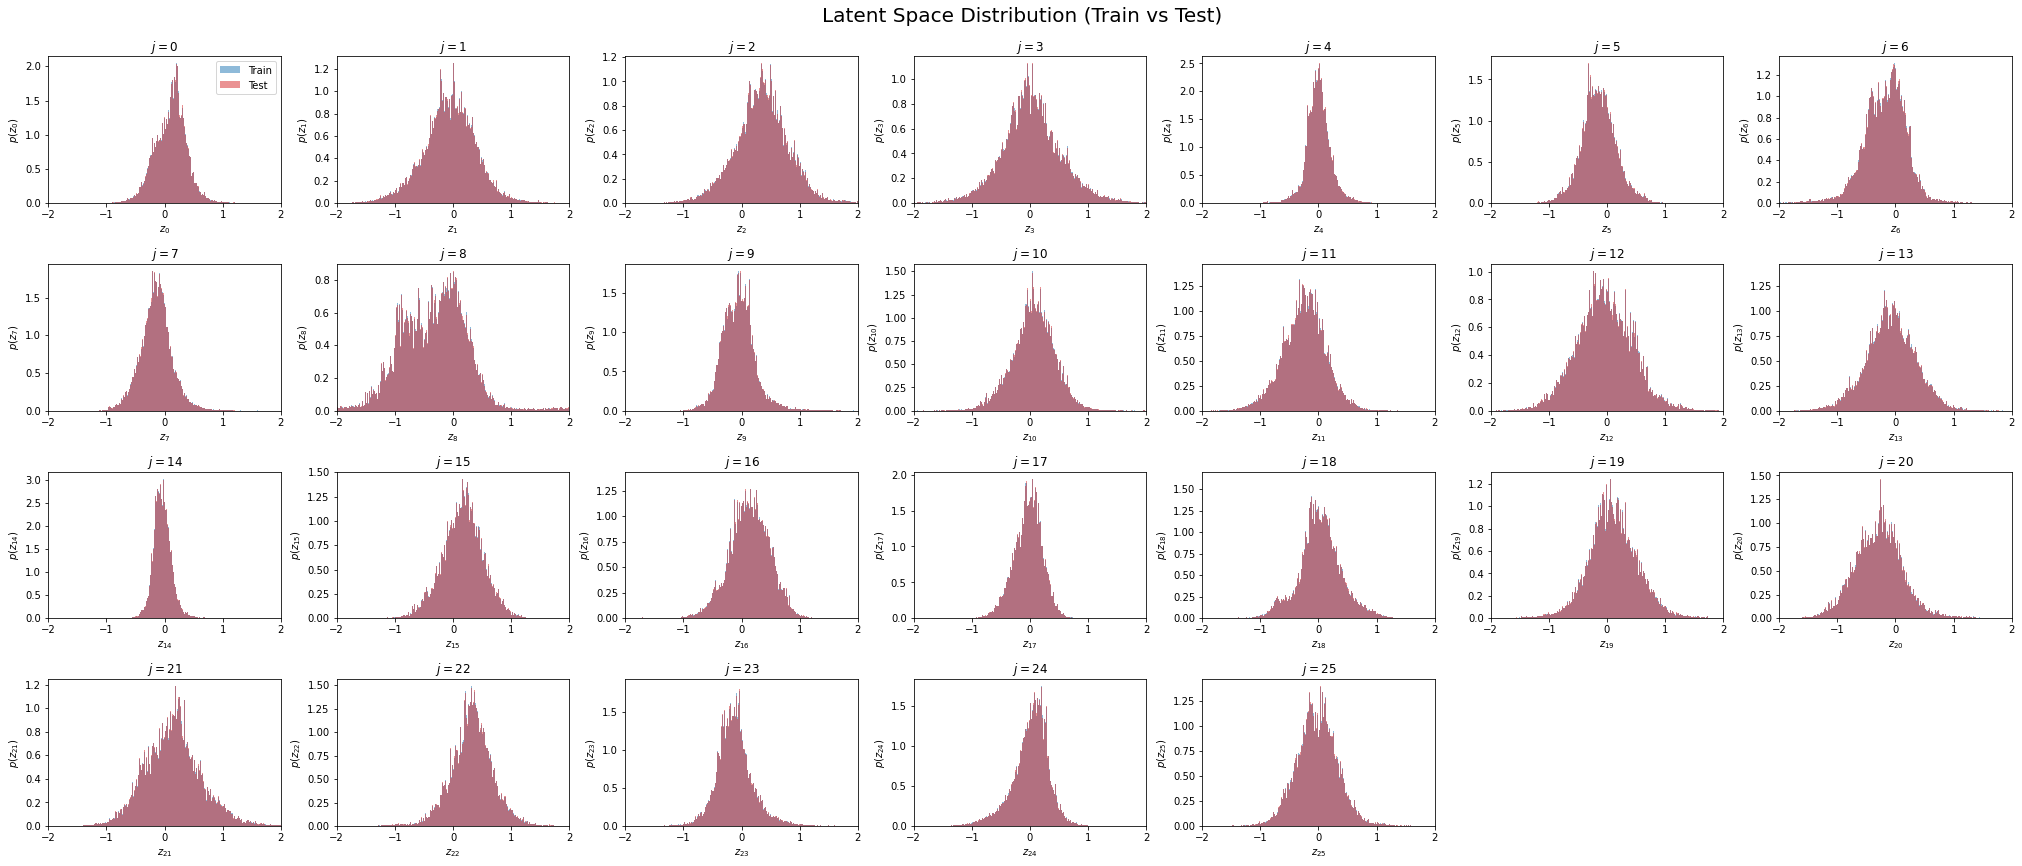

In [139]:
NROWS = 4
NCOLS = int(np.ceil(z_pred.shape[1] / NROWS))

fig, axes = plt.subplots(NROWS, NCOLS, figsize=(28, 12))
fig.suptitle('Latent Space Distribution (Train vs Test)\n', size=20)
fig.tight_layout(h_pad=4, w_pad=2.5)
bins = np.linspace(-2, 2, 256)

for i_row in tqdm(range(NROWS)):
    for i_col in range(NCOLS):
        i_latent = i_row * NCOLS + i_col
        if i_latent >= z_pred.shape[1]:
            axes[i_row][i_col].set_visible(False)
            continue
        axes[i_row][i_col].hist(z_train_pred[:, i_latent], density=True, bins=bins, alpha=0.5, label='Train', color='tab:blue')
        axes[i_row][i_col].hist(z_pred[:, i_latent], density=True, bins=bins, alpha=0.5, label='Test', color='tab:red')
        axes[i_row][i_col].set_title(f'$j={i_latent}$'); axes[i_row][i_col].set_ylabel(r'$p(z_{' + str(i_latent) + r'}$)'); axes[i_row][i_col].set_xlabel(r'$z_{' + str(i_latent) + r'}$')
        axes[i_row][i_col].set_xlim(-2, 2); 
        if i_latent == 0: axes[i_row][i_col].legend();

## Indepencence

100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


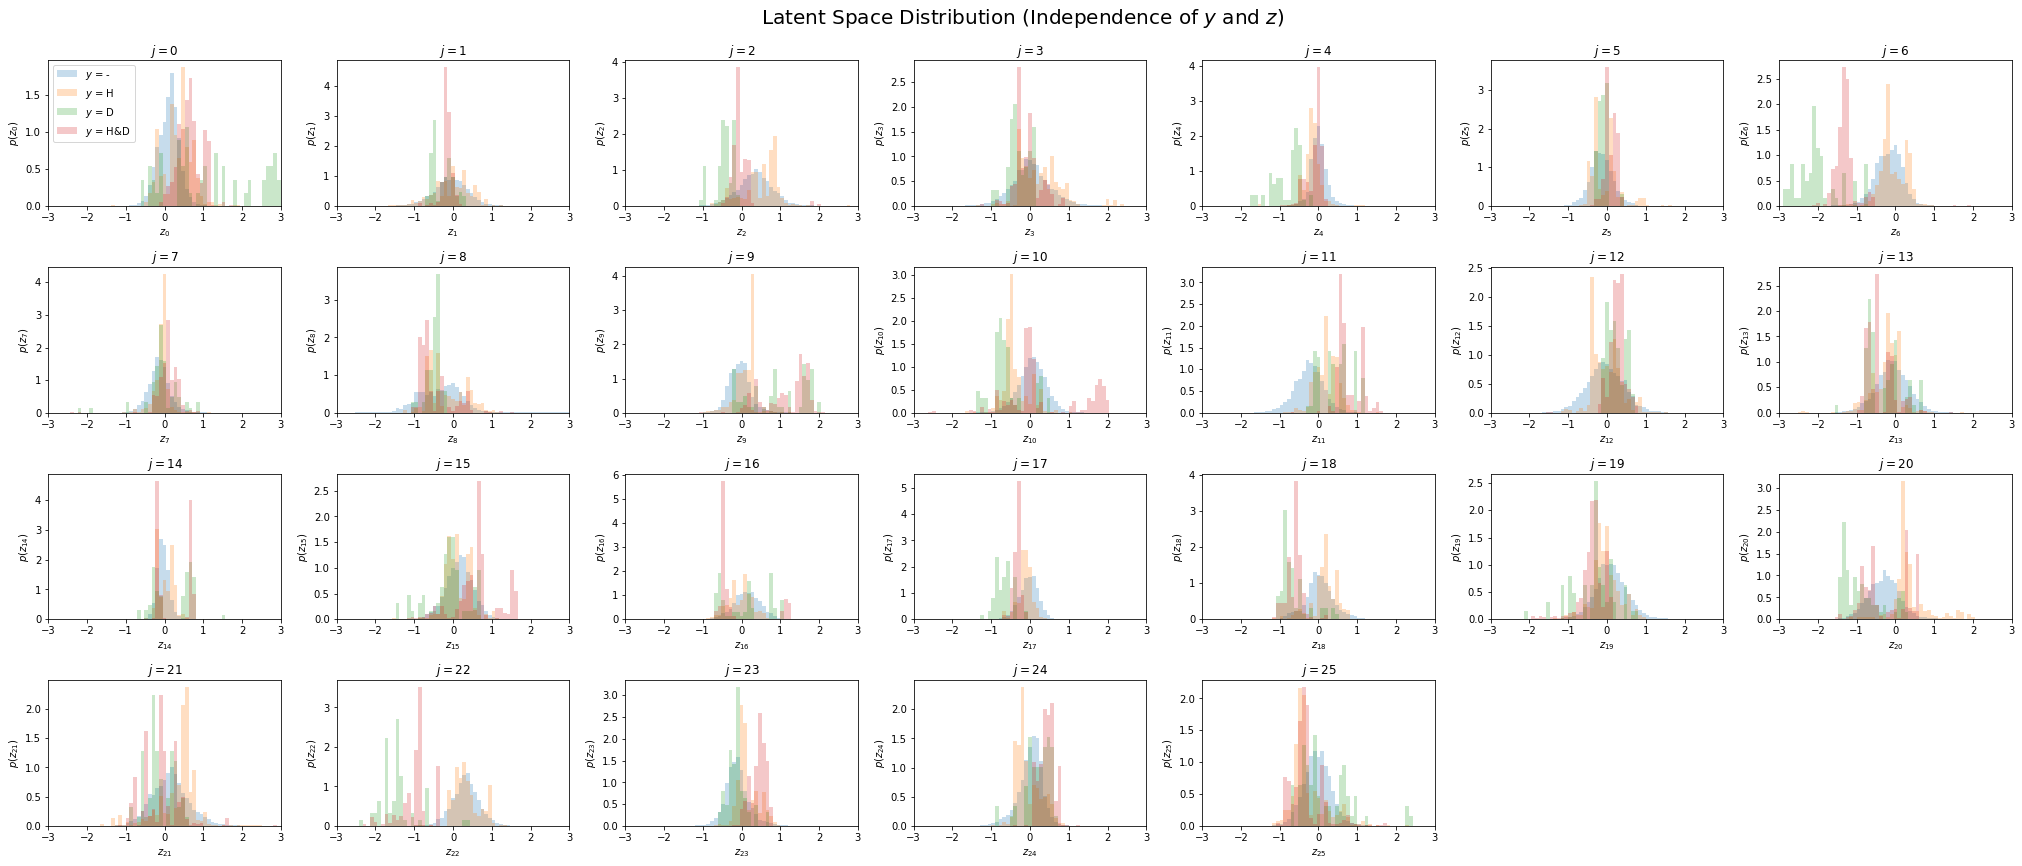

In [121]:
NROWS = 4
NCOLS = int(np.ceil(z_pred.shape[1] / NROWS))

fig, axes = plt.subplots(NROWS, NCOLS, figsize=(28, 12))
fig.suptitle('Latent Space Distribution (Independence of $y$ and $z$)\n', size=20)
fig.tight_layout(h_pad=4, w_pad=2.5)
bins = np.linspace(-3, 3, 64)

for i_row in tqdm(range(NROWS)):
    for i_col in range(NCOLS):
        i_latent = i_row * NCOLS + i_col
        if i_latent >= z_pred.shape[1]:
            axes[i_row][i_col].set_visible(False)
            continue
        axes[i_row][i_col].hist(z_pred[np.logical_and(y_proba_pred[:, 0] < 0.5, y_proba_pred[:, 1] < 0.5), i_latent], density=True, bins=bins, alpha=0.25, label='$y$ = -',)
        axes[i_row][i_col].hist(z_pred[np.logical_and(y_proba_pred[:, 0] >= 0.5, y_proba_pred[:, 1] < 0.5), i_latent], density=True, bins=bins, alpha=0.25, label='$y$ = H',)
        axes[i_row][i_col].hist(z_pred[np.logical_and(y_proba_pred[:, 0] < 0.5, y_proba_pred[:, 1] >= 0.5), i_latent], density=True, bins=bins, alpha=0.25, label='$y$ = D',)
        axes[i_row][i_col].hist(z_pred[np.logical_and(y_proba_pred[:, 0] >= 0.5, y_proba_pred[:, 1] >= 0.5), i_latent], density=True, bins=bins, alpha=0.25, label='$y$ = H&D',)
        axes[i_row][i_col].set_title(f'$j={i_latent}$'); axes[i_row][i_col].set_ylabel(r'$p(z_{' + str(i_latent) + r'}$)'); axes[i_row][i_col].set_xlabel(r'$z_{' + str(i_latent) + r'}$')
        axes[i_row][i_col].set_xlim(-3, 3); 
        if i_latent == 0: axes[i_row][i_col].legend();

In [122]:
keys = ['sex_female','age_0','age_18','age_50','age_65','race_native','race_asian','race_black','race_other','race_native_pacific','race_white','ethnicity_hispanic','case_onset_interval','symptom_status','used_bed_ratio','used_icu_ratio','rural-urban_Continuum Code_2013','urban_influence_code_2013','economic_typology_2015','pop_estimate_2019','less_hs_pct','hs_only_pct','some_college_pct','bachelor_higher_pct','unempl_rate','med_hh_income_19','med_hh_income_pct_state_total_19','poverty_pct_19', ]

def prettyX(X, index=None):
    return pd.DataFrame(X, columns=keys, index=index)

In [123]:
y_zeros = torch.zeros((1, 2)).to(device)
y_h = torch.Tensor([[1, 0]]).to(device)
y_d = torch.Tensor([[0, 1]]).to(device)
y_hd = torch.Tensor([[1, 1]]).to(device)
z_zeros = torch.zeros((1, 26)).to(device)

## Reconstruction: Latent Zeros

In [124]:
x_zeros_pred = inn.inverse(y_zeros, z_zeros).detach().cpu().numpy()
x_h_pred = inn.inverse(y_h, z_zeros).detach().cpu().numpy()
x_d_pred = inn.inverse(y_d, z_zeros).detach().cpu().numpy()
x_hd_pred = inn.inverse(y_hd, z_zeros).detach().cpu().numpy()

In [125]:
x_all = np.concatenate([x_zeros_pred, x_h_pred, x_d_pred, x_hd_pred], axis=0)

In [126]:
prettyX(sc_X_train.inverse_transform(x_all), index=['-', 'H', 'D', 'HD']).T

,-,H,D,HD
sex_female,0.568062,0.571284,0.568141,0.574497
age_0,0.047223,0.050549,0.047379,0.057014
age_18,0.603829,0.493242,0.603672,0.489343
age_50,0.189146,0.202335,0.190431,0.210505
age_65,0.076382,0.140171,0.076273,0.135325
race_native,-0.006507,-0.008061,-0.006596,-0.007282
race_asian,0.009128,0.008893,0.009196,0.009677
race_black,0.057856,0.065589,0.057980,0.069182
race_other,0.026988,0.026470,0.027114,0.025542
race_native_pacific,-0.000662,-0.000516,-0.000628,-0.000178


## Reconstruction: Encodings

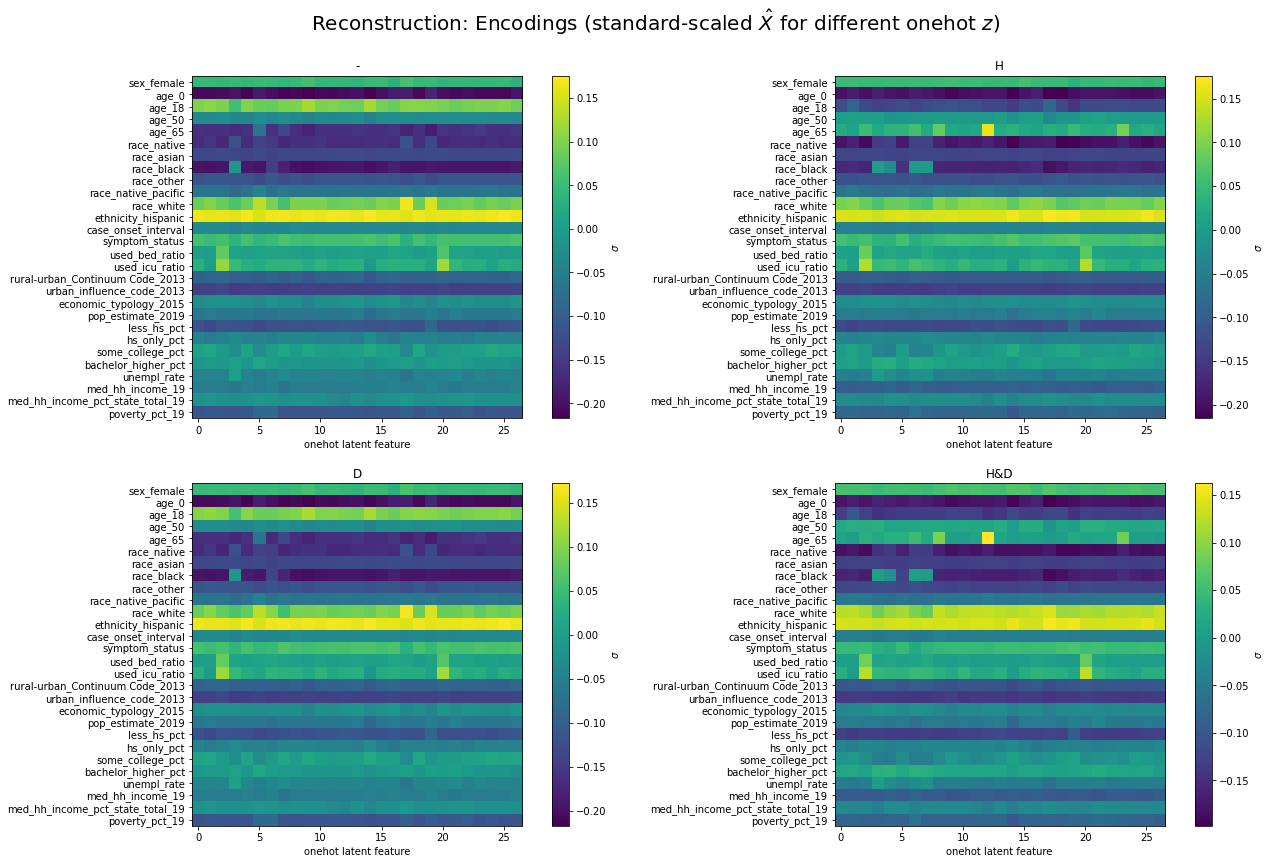

In [131]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.tight_layout(h_pad=5)
fig.suptitle(r'Reconstruction: Encodings (standard-scaled $\hat X$ for different onehot $z$)', size=20);
fig.subplots_adjust(top=0.9)

for i, y_combination, y_combination_name in zip(range(4), [[0,0], [1,0], [0,1], [1,1]], ['-', 'H', 'D', 'H&D']):
    y_zeros = torch.Tensor([y_combination]*27).to(device)
    z_onehot = torch.cat([torch.zeros((1, 26)), F.one_hot(torch.arange(0, 26))], dim=0).to(device)
    x_onehot = inn.inverse(y_zeros, z_onehot)

    img = axes[i//2][i%2].imshow(x_onehot.detach().cpu().T);
    fig.colorbar(img, ax=axes[i//2][i%2], label='$\sigma$');
    axes[i//2][i%2].set_xlabel('onehot latent feature'); axes[i//2][i%2].set_title(y_combination_name)
    axes[i//2][i%2].set_yticks(np.arange(28))
    axes[i//2][i%2].set_yticklabels(keys);

In [ ]:
# IDEA: personal data -> latent representation -> set y = 0 -> inverse -> observe what changed

In [140]:
for i, y_label in enumerate(['hosp', 'death']):
    print(f'--- {y_label} ---')
    evaluation_results[y_label] = np.concatenate([1 - y_proba_pred[:, i].reshape(-1, 1), y_proba_pred[:, i].reshape(-1, 1)], axis=1)

    print(f'binary cross-entropy: {np.round(log_loss(y_test[:, i], evaluation_results[y_label][:, 1]), 4)}')
    print(f'brier loss: {brier_score_loss(y_test[:, i], evaluation_results[y_label][:, 1]).round(4)}')
    print(f'accuracy: {accuracy_score(y_test[:, i], evaluation_results[y_label][:, 1].round()).round(4)}')
    print('confusion matrix:')
    print(confusion_matrix(y_test[:, i], (evaluation_results[y_label][:, 1] > 0.5).astype(int)))
    print()

--- hosp ---
binary cross-entropy: 0.2144
brier loss: 0.0576
accuracy: 0.9313
confusion matrix:
[[584675    947]
 [ 42365   2303]]

--- death ---
binary cross-entropy: 0.0563
brier loss: 0.0115
accuracy: 0.9876
confusion matrix:
[[621469     17]
 [  7789   1015]]



In [141]:
with open('../evaluation_results/models/INN.pt', 'wb') as file:
    pickle.dump(evaluation_results, file)